# DGA Detection
## Experiment 3
<b><p id="intro" style="color: green">In this notebook we use the full dataset "dga_data_full.csv", apply the function for N-gram feature extraction and extract TLD feature from domain string.</p></b>
<a href="#WorkingOn">Go back</a>

In [359]:
# Load libraries 
import pandas as pd
import numpy as np
import regex as re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

from pickle import dump
from pickle import load

<b><h3>Part 1 - Data Preprocessing</h3></b>

In [360]:
df = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1//data/raw/dga_data_full.csv')
df.head()

,isDGA,domain,host,subclass
0,dga,6xzxsw3sokvg1tc752y1a6p0af,6xzxsw3sokvg1tc752y1a6p0af.com,gameoverdga
1,dga,glbtlxwwhbnpxs,glbtlxwwhbnpxs.ru,cryptolocker
2,dga,xxmamopyipbfpk,xxmamopyipbfpk.ru,cryptolocker
3,dga,zfd5szpi18i85wj9uy13l69rg,zfd5szpi18i85wj9uy13l69rg.net,newgoz
4,dga,jpqftymiuver,jpqftymiuver.ru,cryptolocker


In [361]:
print(df.shape)
missing_values = df.isnull().sum()
print(missing_values)

(160000, 4)
isDGA       0
domain      2
host        0
subclass    0
dtype: int64


In [362]:
# Drop the rows with missing values
df = df.dropna()
print(df.shape)

(159998, 4)


In [363]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(duplicates)

0


In [364]:
print(f"DGA: {df['isDGA'].value_counts()['dga']}")
print(f"Legit: {df['isDGA'].value_counts()['legit']}")

DGA: 80000
Legit: 79998


<b><h3>Part 2 - Feature Engineering</h3></b>

In [365]:
df.drop(['domain', 'subclass'], axis=1, inplace=True)
print(df.shape)
df.head()

(159998, 2)


,isDGA,host
0,dga,6xzxsw3sokvg1tc752y1a6p0af.com
1,dga,glbtlxwwhbnpxs.ru
2,dga,xxmamopyipbfpk.ru
3,dga,zfd5szpi18i85wj9uy13l69rg.net
4,dga,jpqftymiuver.ru


In [366]:
df.rename(columns={'host':'domain_name'}, inplace=True)

In [367]:
df['isDGA'] = df['isDGA'].apply(lambda x: 1 if x == 'dga' else 0)
df.head()

,isDGA,domain_name
0,1,6xzxsw3sokvg1tc752y1a6p0af.com
1,1,glbtlxwwhbnpxs.ru
2,1,xxmamopyipbfpk.ru
3,1,zfd5szpi18i85wj9uy13l69rg.net
4,1,jpqftymiuver.ru


In [368]:
df['domain_name_length'] = df['domain_name'].apply(lambda x: len(x))
df.head()

,isDGA,domain_name,domain_name_length
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30
1,1,glbtlxwwhbnpxs.ru,17
2,1,xxmamopyipbfpk.ru,17
3,1,zfd5szpi18i85wj9uy13l69rg.net,29
4,1,jpqftymiuver.ru,15


In [369]:
# Function to get the top level domain from 'host' and its length and add both as 2 new columns 'tld' and 'tld_length' 
def get_tld_length(domain):
    tld = domain.split('.')[-1]
    tld_length = len(tld)
    return tld, tld_length

df['tld'], df['tld_length'] = zip(*df['domain_name'].map(get_tld_length))
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3
1,1,glbtlxwwhbnpxs.ru,17,ru,2
2,1,xxmamopyipbfpk.ru,17,ru,2
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3
4,1,jpqftymiuver.ru,15,ru,2


In [370]:
# Function to calculate number of digits 
def numDigits(domain):
    return sum(c.isdigit() for c in domain)

# Function to get the index of the first digit in a string
def firstDigitIndex(domain):
    for i, c in enumerate(domain):
        if c.isdigit():
            return i + 1
    return 0

In [371]:
df['digits'] = df['domain_name'].apply(lambda x: numDigits(x))
df['first_digit_idx'] = df['domain_name'].apply(lambda x: firstDigitIndex(x))
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length,digits,first_digit_idx
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3,9,1
1,1,glbtlxwwhbnpxs.ru,17,ru,2,0,0
2,1,xxmamopyipbfpk.ru,17,ru,2,0,0
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3,10,4
4,1,jpqftymiuver.ru,15,ru,2,0,0


In [372]:
# Calculate vowel to consonant ratio
def vowel_consonant_ratio(x):    
    x = x.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, x)
    consonants = re.findall(consonants_pattern, x)
    try:
        ratio = len(vowels) / len(consonants)
    except: # catch zero devision exception 
        ratio = 0  
    return ratio

In [373]:
df['vowel_cons_ratio'] = df['domain_name'].apply(lambda x: vowel_consonant_ratio(x))
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length,digits,first_digit_idx,vowel_cons_ratio
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3,9,1,0.250000
1,1,glbtlxwwhbnpxs.ru,17,ru,2,0,0,0.066667
2,1,xxmamopyipbfpk.ru,17,ru,2,0,0,0.333333
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3,10,4,0.285714
4,1,jpqftymiuver.ru,15,ru,2,0,0,0.400000


In [375]:
# Function to calculate Shannon Entropy
def H_entropy(x):
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

In [376]:
df['entropy'] = df['domain_name'].apply(lambda x: H_entropy(x))
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length,digits,first_digit_idx,vowel_cons_ratio,entropy
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3,9,1,0.250000,4.440224
1,1,glbtlxwwhbnpxs.ru,17,ru,2,0,0,0.066667,3.616875
2,1,xxmamopyipbfpk.ru,17,ru,2,0,0,0.333333,3.572469
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3,10,4,0.285714,4.444188
4,1,jpqftymiuver.ru,15,ru,2,0,0,0.400000,3.640224


In [377]:
top_english_words = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1//data/raw/google-10000-english.txt', header=None, names=['words'])
top_english_words.head()
d = top_english_words
# Save as pickle file
dump(d, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/data/raw/top_english_words.pkl', 'wb'))

In [378]:
with open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/data/raw/top_english_words.pkl', 'rb') as f:
    d = load(f)

# ngrams: Implementation according to Schiavoni 2014: "Phoenix: DGA-based Botnet Tracking and Intelligence"
def ngrams(word, n):    
    l_ngrams = []
    if isinstance(word, list):
        for w in word:
            if isinstance(n, list):
                for curr_n in n:
                    ngrams = [w[i:i+curr_n] for i in range(0,len(w)-curr_n+1)]
                    l_ngrams.extend(ngrams)
            else:
                ngrams = [w[i:i+n] for i in range(0,len(w)-n+1)]
                l_ngrams.extend(ngrams)
    else:
        if isinstance(n, list):
            for curr_n in n:
                ngrams = [word[i:i+curr_n] for i in range(0,len(word)-curr_n+1)]
                l_ngrams.extend(ngrams)
        else:
            ngrams = [word[i:i+n] for i in range(0,len(word)-n+1)]
            l_ngrams.extend(ngrams)
#     print(l_ngrams)
    return l_ngrams

def ngram_feature(domain, d, n):    
    l_ngrams = ngrams(domain, n)
#     print(l_ngrams)
    count_sum=0
    for ngram in l_ngrams:
        if ngram in d:
            count_sum+=d[ngram]
    
    try:
        feature = count_sum/(len(domain)-n+1)

    except:
        feature = 0
    
    return feature
    
def average_ngram_feature(l_ngram_feature):   
    return sum(l_ngram_feature)/len(l_ngram_feature)

In [379]:
dict_freq = { word[0]: num for num, word in enumerate(d.values, 1) }

In [380]:
df['ngrams'] = df['domain_name'].apply(lambda x: average_ngram_feature([ngram_feature(x, dict_freq, n) for n in [1,2,3]]))
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length,digits,first_digit_idx,vowel_cons_ratio,entropy,ngrams
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3,9,1,0.250000,4.440224,453.223536
1,1,glbtlxwwhbnpxs.ru,17,ru,2,0,0,0.066667,3.616875,1136.419118
2,1,xxmamopyipbfpk.ru,17,ru,2,0,0,0.333333,3.572469,1032.404412
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3,10,4,0.285714,4.444188,378.545947
4,1,jpqftymiuver.ru,15,ru,2,0,0,0.400000,3.640224,1402.937851


In [303]:
# Save the df as a new csv file named 'dga_features_pr3.csv'
df.to_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/data/processed/dga_features_pr3.csv', index=False)

<b><h3>Part 3 - Data Visualization</h3></b>

In [381]:
df_final = df.copy()

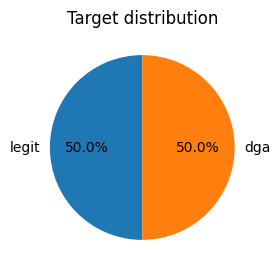

In [382]:
plt.figure(figsize=(3,3))
plt.pie(y.value_counts(), labels=['legit', 'dga'], autopct='%1.1f%%', startangle=90)
plt.title('Target distribution')
plt.show()

<Axes: xlabel='ngrams', ylabel='Count'>

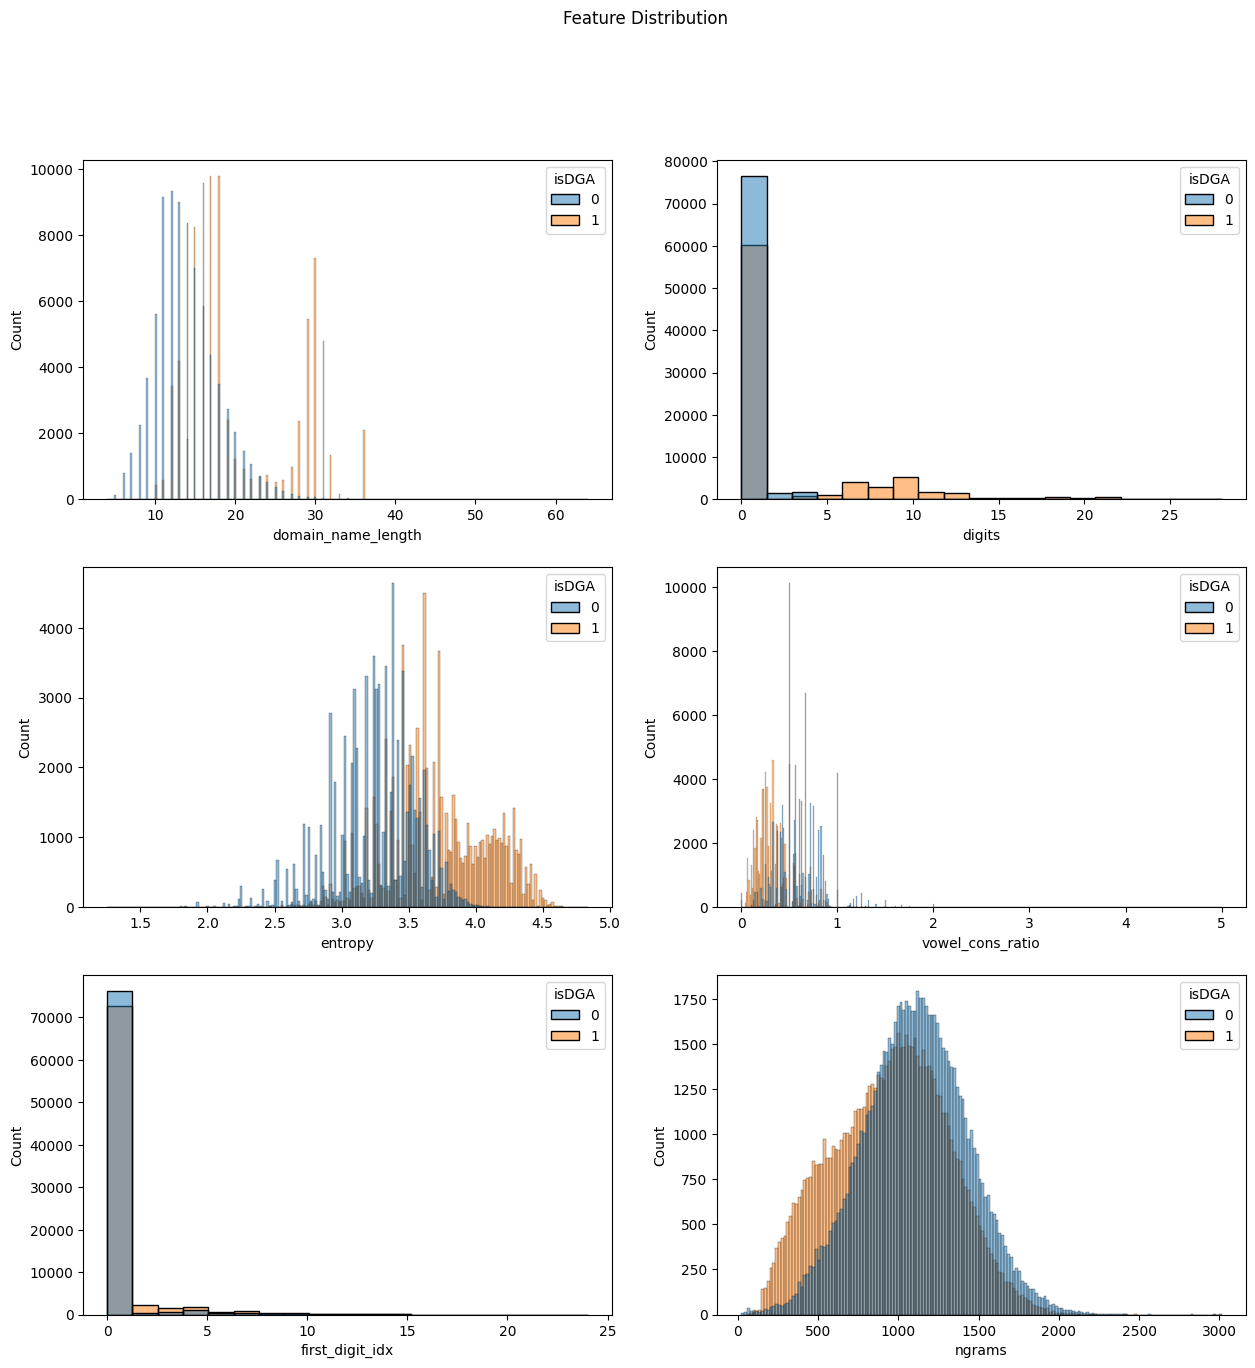

In [383]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Feature Distribution')

sns.histplot(data=df_final, x='domain_name_length', hue='isDGA', ax=axes[0, 0])
sns.histplot(data=df_final, x='digits', hue='isDGA', ax=axes[0, 1])
sns.histplot(data=df_final, x='entropy', hue='isDGA', ax=axes[1, 0])
sns.histplot(data=df_final, x='vowel_cons_ratio', hue='isDGA', ax=axes[1, 1])
sns.histplot(data=df_final, x='first_digit_idx', hue='isDGA', ax=axes[2, 0])
sns.histplot(data=df_final, x='ngrams', hue='isDGA', ax=axes[2, 1])

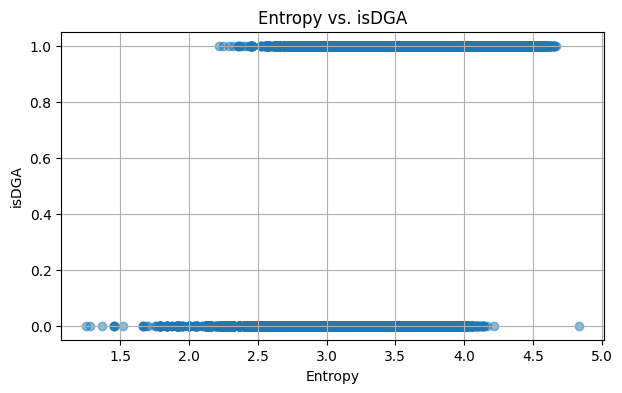

In [384]:
plt.figure(figsize=(7, 4))
plt.scatter(df_final['entropy'], df_final['isDGA'], alpha=0.5)
plt.xlabel('Entropy')
plt.ylabel('isDGA')
plt.title('Entropy vs. isDGA')
plt.grid(True)
plt.show()

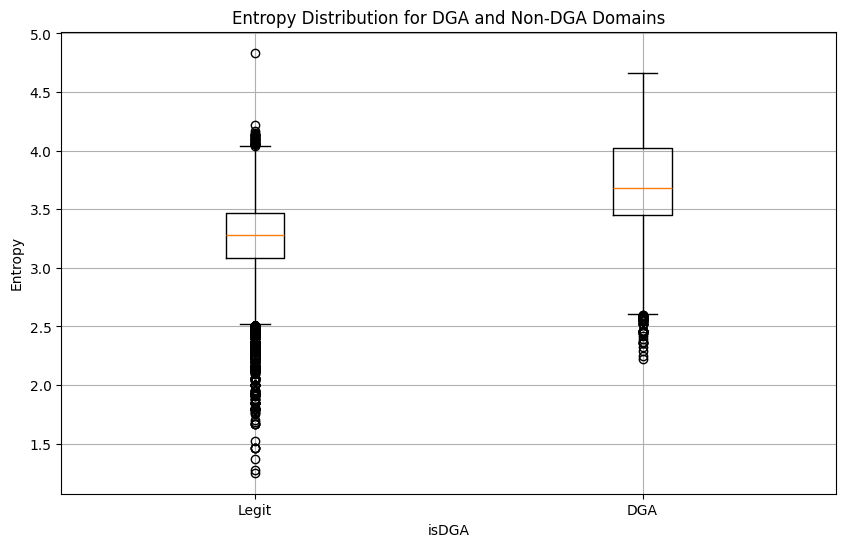

In [385]:
plt.figure(figsize=(10, 6))
plt.boxplot([df_final[df_final['isDGA'] == 0]['entropy'], df_final[df_final['isDGA'] == 1]['entropy']], labels=['Legit', 'DGA'])
plt.xlabel('isDGA')
plt.ylabel('Entropy')
plt.title('Entropy Distribution for DGA and Non-DGA Domains')
plt.grid(True)
plt.show()

In [ ]:
# The box plot shows that DGA domains have higher entropy than legit domains 

In [386]:
df_final.drop(['domain_name', 'tld'], axis=1, inplace=True)
df_final.head() 

,isDGA,domain_name_length,tld_length,digits,first_digit_idx,vowel_cons_ratio,entropy,ngrams
0,1,30,3,9,1,0.250000,4.440224,453.223536
1,1,17,2,0,0,0.066667,3.616875,1136.419118
2,1,17,2,0,0,0.333333,3.572469,1032.404412
3,1,29,3,10,4,0.285714,4.444188,378.545947
4,1,15,2,0,0,0.400000,3.640224,1402.937851


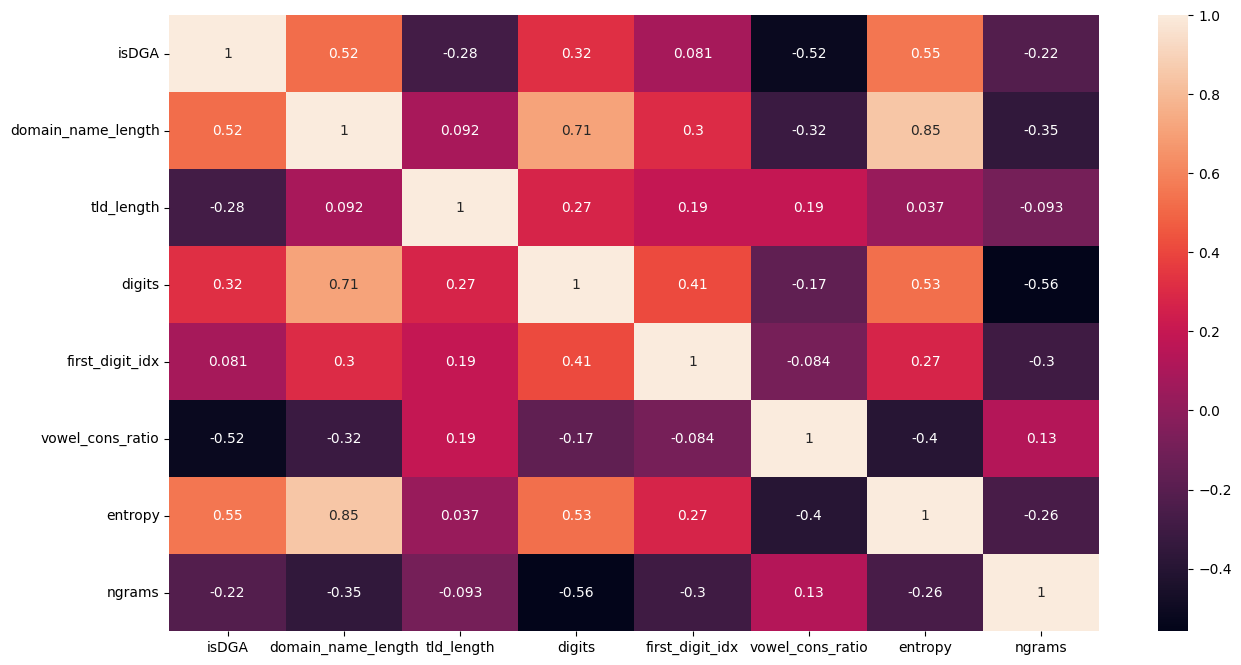

In [387]:
corr = df_final.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr, annot=True)   
plt.show()

<b><h3>Part 3 - Training the Decision Tree Classifier model</h3></b>

In [388]:
X = df_final[['domain_name_length', 'digits', 'entropy', 'vowel_cons_ratio', 'ngrams']]
y = df_final['isDGA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [389]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [390]:
y_pred = dt_clf.predict(X_test)

In [391]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 82.18%


In [392]:
hyperparams_dt = {'criterion': ['gini', 'entropy', 'log_loss'], 
                  'max_depth': [None, 5, 15, 20, 25], 
                  'min_samples_split': [2, 5, 10, 20], 
                  'min_samples_leaf': [1, 2, 4, 5]}

dt_clf_grid = GridSearchCV(dt_clf, hyperparams_dt, cv=5)
dt_clf_grid

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 15, 20, 25],
                         'min_samples_leaf': [1, 2, 4, 5],
                         'min_samples_split': [2, 5, 10, 20]})

In [393]:
dt_clf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 15, 20, 25],
                         'min_samples_leaf': [1, 2, 4, 5],
                         'min_samples_split': [2, 5, 10, 20]})

In [394]:
print(f"Best hyperparameters: {dt_clf_grid.best_params_}") 

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 20}


In [395]:
dt_clf_optimized = DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=4, min_samples_split=20, random_state=42)
dt_clf_optimized.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=4,
                       min_samples_split=20, random_state=42)

In [396]:
y_pred_dt_opt = dt_clf_optimized.predict(X_test)

In [397]:
accuracy_dt_opt = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy_dt_opt * 100.0))

Accuracy score: 82.18%


In [355]:
dump(dt_clf_optimized, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr3_dt_clf_opt.pkl', 'wb'))

<b><h3>Part 4 - Training other classifiers</h3></b>
<h4 style="color: red">Random Forest Classifier</h4>

In [398]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [399]:
y_pred_rf = rf_clf.predict(X_test)

In [400]:
accuracy_rf = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy_rf * 100.0))

Accuracy score: 82.18%


In [104]:
hyperparameters = {'n_estimators': [50, 100, 150, 200], 
                     'criterion': ['gini', 'entropy', 'log_loss'], 
                     'max_depth': [None, 5, 15, 20, 25], 
                     'min_samples_split': [2, 5, 10, 20], 
                     'min_samples_leaf': [1, 2, 4, 5]} 

grid_rf = GridSearchCV(rf_clf, hyperparameters, cv=10) 
grid_rf

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 15, 20, 25],
                         'min_samples_leaf': [1, 2, 4, 5],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 150, 200]})

In [327]:
rf_clf_optimized = RandomForestClassifier(n_estimators=100, 
                                    criterion='gini', 
                                    max_depth=15, 
                                    min_samples_leaf=5, 
                                    min_samples_split=20, 
                                    random_state=42)
rf_clf_optimized.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=5, min_samples_split=20,
                       random_state=42)

In [328]:
y_pred_rf_opt = rf_clf_optimized.predict(X_test)

In [330]:
accuracy_rf_opt = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy_rf_opt * 100.0))

Accuracy score: 85.95%


In [331]:
# Save the model
dump(rf_clf_optimized, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr3_rf_clf_opt.pkl', 'wb'))

<h4 style="color: red">K-NN Classifier</h4>

In [332]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [333]:
y_pred_knn = knn_clf.predict(X_test)

In [334]:
accuracy_knn = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy_knn * 100.0))

Accuracy score: 85.95%


In [335]:
knn_clf_optimized = KNeighborsClassifier(n_neighbors=7, 
                                   weights='distance', 
                                   leaf_size=10, 
                                   p=1, 
                                   algorithm='kd_tree')
knn_clf_optimized.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, n_neighbors=7, p=1,
                     weights='distance')

In [336]:
y_pred_knn_opt = knn_clf_optimized.predict(X_test)

In [337]:
accuracy_knn_opt = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy_knn_opt * 100.0))

Accuracy score: 85.95%


In [338]:
dump(knn_clf_optimized, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr3_knn_clf_opt.pkl', 'wb'))

<h4 style="color: red">Boosting Algorithms</h4>

In [339]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [340]:
y_pred_xgb = xgb_clf.predict(X_test)

In [341]:
accuracy_xgb = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy_xgb * 100.0))

Accuracy score: 85.95%


In [342]:
xgb_clf_opt = XGBClassifier(n_estimators=200, 
                            max_depth=7, 
                            learning_rate=0.1, 
                            subsample=0.7, 
                            colsample_bytree=0.7, 
                            gamma=50, 
                            random_state=42)

xgb_clf_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=50, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [343]:
y_pred = xgb_clf_opt.predict(X_test)

In [344]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 85.84%


In [159]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier()

In [160]:
y_pred = gb_clf.predict(X_test)

In [161]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 85.83%


In [162]:
# optimize the hyperparameters of the Gradient Boosting Classifier using a Randomized Search
hyperparameters = {'n_estimators': [50, 100, 150, 200], 
                     'learning_rate': [0.01, 0.1, 0.5, 1], 
                     'subsample': [0.5, 0.7, 1.0], 
                     'max_depth': [3, 5, 7, 9], 
                     'min_samples_split': [2, 5, 10, 20], 
                     'min_samples_leaf': [1, 2, 4, 5], 
                     'max_features': ['auto', 'sqrt', 'log2']}

random_gb = RandomizedSearchCV(gb_clf, hyperparameters, cv=10, n_iter=100, random_state=42)
random_gb

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_iter=100,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.5, 1],
                                        'max_depth': [3, 5, 7, 9],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 5],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [50, 100, 150, 200],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=42)

In [163]:
# Fit the model
random_gb.fit(X_train, y_train)

# Get the best parameters
print(f"Best parameters found: {random_gb.best_params_}")

KeyboardInterrupt: 

<a id="WorkingOn" href="#intro">Go up</a>